In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import nibabel as nib
import os
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPooling3D, BatchNormalization, Dropout, concatenate, Flatten
from sklearn.model_selection import train_test_split
from pathlib import Path
from DataGenerator import DataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [104]:
import shutil


In [2]:
petinput = Input(shape = (182, 218, 182, 1))
mriinput = Input(shape = (182, 218, 182, 1))

In [31]:
x = Conv3D(16, kernel_size = 3, activation = "relu", kernel_initializer='he_uniform', input_shape = (182, 218, 182, 1))(petinput)
x = MaxPooling3D(pool_size = (2,2,2))(x)
x = BatchNormalization(center=True, scale=True)(x)
x = Dropout(0.2)(x)
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = BatchNormalization(center=True, scale=True)(x)
x = Dropout(0.2)(x)
x = Model(inputs = petinput, outputs = x)

y = Conv3D(16, kernel_size = 3, activation = "relu", kernel_initializer='he_uniform', input_shape = (182, 218, 182, 1))(mriinput)
y = MaxPooling3D(pool_size = (2,2,2))(y)
y = BatchNormalization(center=True, scale=True)(y)
y = Dropout(0.2)(y)
y = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform')(y)
y = MaxPooling3D(pool_size=(2, 2, 2))(y)
y = BatchNormalization(center=True, scale=True)(y)
y = Dropout(0.2)(y)
y = Model(inputs = mriinput, outputs = y)

end = concatenate([x.output, y.output])
z = Flatten()(end)
z = Dense(32, activation='relu', kernel_initializer='he_uniform')(z)
z = Dense(32, activation='relu', kernel_initializer='he_uniform')(z)
z = Dense(10, activation='relu')(z)
z = Dense(1, activation = "sigmoid")(z)
model = Model(inputs=[x.input, y.input], outputs=z)

model.summary

In [32]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 182, 218, 18 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 182, 218, 18 0                                            
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 180, 216, 180 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 180, 216, 180 448         input_2[0][0]                    
____________________________________________________________________________________________

In [5]:
alz = pd.read_csv("alzheimers.csv").drop_duplicates()
conv = pd.read_csv("converted.csv").drop_duplicates()
non = pd.read_csv("nonconverted.csv").drop_duplicates()
cont = pd.read_csv("control.csv").drop_duplicates()

In [6]:

for index, row in alz.iterrows():
    if not Path("petregistered/" + str(row["PET_ID"]) + "_registered.nii.gz").exists():
        alz = alz.drop(index)


for index, row in cont.iterrows():
    if not Path("petregistered/" + str(row["PET_ID"]) + "_registered.nii.gz").exists():
        cont = cont.drop(index)
        
for index, row in alz.iterrows():
    if not Path("registered/" + str(row["MRI_ID"]) + "_registered.nii.gz").exists():
        alz = alz.drop(index)


for index, row in cont.iterrows():
    if not Path("registered/" + str(row["MRI_ID"]) + "_registered.nii.gz").exists():
        cont = cont.drop(index)        

posmarker = np.ones(len(alz))
negmarker = np.zeros(len(cont))

Subject ID    007_S_0316
MRI_ID             36567
PET_ID             26491
Name: 18, dtype: object
Subject ID    006_S_4449
MRI_ID            412372
PET_ID            282605
Name: 12, dtype: object
Subject ID    023_S_4020
MRI_ID            233460
PET_ID            242607
Name: 75, dtype: object
Subject ID    035_S_4082
MRI_ID            296309
PET_ID            248342
Name: 94, dtype: object
Subject ID    094_S_0489
MRI_ID             47040
PET_ID             27906
Name: 138, dtype: object
Subject ID    116_S_4483
MRI_ID            281407
PET_ID            287394
Name: 156, dtype: object
Subject ID    136_S_4269
MRI_ID            265204
PET_ID            274773
Name: 172, dtype: object


In [7]:
alz["marker"] = posmarker
cont["marker"] = negmarker
subjects = alz.append(cont)
ids = subjects[["PET_ID", "MRI_ID"]]
markers = subjects["marker"]

In [34]:
ids_train, ids_val, markers_train, markers_val = train_test_split(ids, markers, random_state = 42, stratify = markers, test_size = .25)

model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["mae", "acc"])


markers_train.iloc[2]

#train_dataset = tf.data.Dataset.from_tensor_slices((ids_train, markers_train)).map(grabfile)
#val_dataset = tf.data.Dataset.from_tensor_slices((ids_val, markers_val))
checkpoint_filepath = 'temp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq = "epoch",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

batch_size = 2
train_generator = DataGenerator(ids_train, markers_train, batch_size = batch_size)
val_generator = DataGenerator(ids_val, markers_val, batch_size = batch_size)

model.fit(train_generator, validation_data = val_generator, callbacks=[model_checkpoint_callback], epochs = 5)

Epoch 1/5
124/125 [============================>.] - ETA: 28s - loss: 0.6930 - mae: 0.4999 - acc: 0.5121

KeyboardInterrupt: 

In [28]:
model.summary().dense_3

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 182, 218, 18 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 182, 218, 18 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 180, 216, 180 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 180, 216, 180 448         input_2[0][0]                    
____________________________________________________________________________________________

AttributeError: 'NoneType' object has no attribute 'dense_3'

In [40]:
val_generator.__getitem__(2)

([[array([[[[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],
   
           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],
   
           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],
   
           ...,
   
           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
           

In [ ]:
np.array([[[2],[5],[1]],[[1],[2],[3]]]).shape

In [ ]:
train_generator.__getitem__(16)[0][0]

In [ ]:
len(train_generator._generate_X([ids_train.iloc[k] for k in range(1)])[0])

In [ ]:
[markers_train.iloc[k] for k in range(1)]

In [ ]:
markers_train

In [ ]:
ids_train.iloc[1]

In [29]:
model.evaluate(val_generator)

33/42 [======================>.......] - ETA: 28s - loss: 0.6928 - mae: 0.4997 - acc: 0.5152

KeyboardInterrupt: 

In [59]:
model.load_weights('model.h5')

NameError: name 'model' is not defined

In [261]:
img = nib.load("brains/322646.nii.gz")
img = img.get_fdata().squeeze()
print(img.shape)

(176, 240, 256)


In [262]:
import matplotlib.pyplot as plt
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [267]:
slice_0 = img[90, :, :]
slice_1 = img[:, 100, :]
slice_2 = img[:, :, 160]

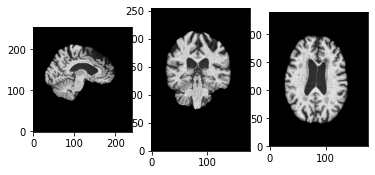

In [268]:
show_slices([slice_0, slice_1, slice_2])


In [202]:
for root, directories, files in os.walk("data"):
    for directory in directories:
        if "Mask" in directory:
            shutil.rmtree(root)


In [245]:
PET = patients.loc[(patients["Modality"] == "PET")]["Image ID"].values


In [244]:
patients = pd.read_csv("idaSearch_7_07_2021 (3).csv")


In [247]:
347757 in PET

True